### 5.4 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline
warnings.filterwarnings(action='ignore')

# 데이터 로드
boston = load_boston()

bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :', bostonDF.shape)
bostonDF.head(3)

Boston 데이타셋 크기 : (506, 14)


C:\Users\82109\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [2]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


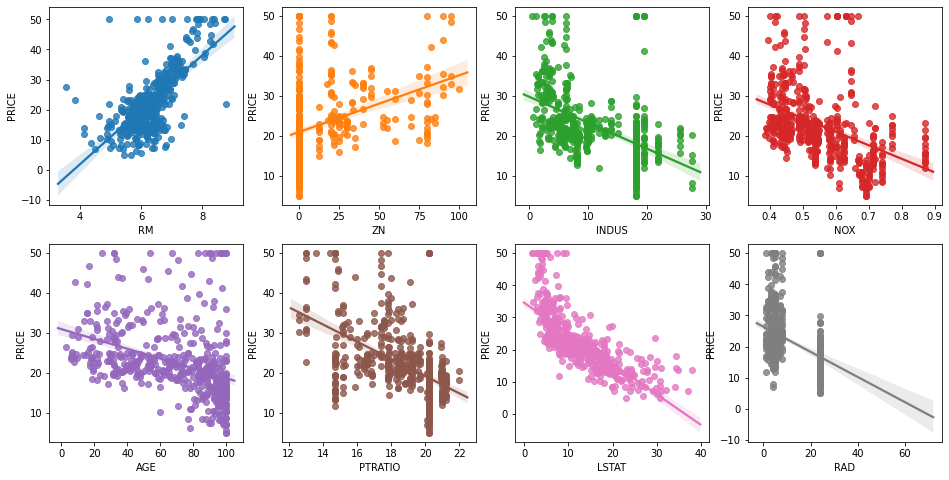

In [3]:
# 'RM' - 거주할 수 있는 방 개수
# 'ZN' - 거주지역의 비율
#'INDUS' - 비상업 지역의 넓이 비율
# 'NOX' - 일산화질소 농도
# 'AGE' - 1940년 이전에 건축된 소유 주택의 비율
# 'PTRATIO' - 지역의 교사와 학생 수 비율
# 'LSTAT' - 하위 계층의 비율
# 'RAD' - 고속도로 접근 용이도

fig, axs = plt.subplots(figsize=(16,8), ncols = 4, nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax = axs[row][col])

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_data,y_target,test_size = 0.3, random_state = 156)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2))


MSE : 17.306, RMSE : 4.160
Variance score : 0.757


In [5]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [6]:
coeff = pd.Series(data=np.round(lr.coef_,1),index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
INDUS       0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [7]:
from sklearn.model_selection import cross_val_score

neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error",cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE scores: ', avg_rmse)


 5 folds 의 개별 Negative MSE scores:  [-12.48 -26.1  -33.12 -80.83 -33.58]
 5 folds 의 개별 RMSE scores:  [3.53 5.11 5.75 8.99 5.8 ]
 5 folds 의 평균 RMSE scores:  5.836431226523905


### 5-5. Polynomial Regression과 오버피팅/언더피팅 이해

#### Polynomial Regression 이해

In [8]:
# 단항식을 다항식으로 바꿔주는 라이브러리
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n',X)

# degree = 2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree = 2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('뱐환된 2차 다항식 계수 feature:\n',poly_ftr)



일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
뱐환된 2차 다항식 계수 feature:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


3차 다항식 결정값을 구하는 함수 polynomial_func(X) 생성. 즉 회귀식은 결정값 y = 1 + 2x_1 + 3x_1^2 + 4x_2^3

In [9]:
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

X = np.arange(0,4).reshape(2,2)
print('일차 단항식 계수 feature : \n' , X)
y = polynomial_func(X)
print('삼차 다항식 결정값 : \n' , y)

일차 단항식 계수 feature : 
 [[0 1]
 [2 3]]
삼차 다항식 결정값 : 
 [  5 125]


In [13]:
# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree = 3).fit_transform(X)
print('3차 다항식 계수 feature: \n', poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수 \n', np.round(model.coef_, 2))
print('Polynomial 회귀 shape', model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 shape (10,)


피쳐가 degree의 수만큼 조합되어 나왔음을 알 수 있음(3차 다항식, 절편 포함)

- pipeline을 통해 전처리와 모델링을 연결한 후 실행

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

# Pipeline 객체로 Streamline하게 Polynomial Feature 변환과 Linear Regression을 연결
model = Pipeline([('poly',PolynomialFeatures(degree = 3)),
                 ('linear', LinearRegression())])

X = np.arange(0,4).reshape(2,2)
y = polynomial_func(X)

model = model.fit(X, y)
print('Polynomial 회귀 계수 \n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


### Polynomial Regression을 이용한 Underfitting, Overfitting 이해

- 다항식의 차수가 높아질수록 매우 복잡한 피쳐간의 관계까지 모델링이 가능함
- 하지만 차수가 높아질수록 과적합의 문제가 발생

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# random 값으로 구성된 X값에 대해 Cosine 변환값을 반환
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 random한 값을 순서대러 sampling한 데이터
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y값은 cosine 기반의 true_fum() 에서 약간의 Nosie 변동값을 더한 값
y = true_fun(X) + np.random.randn(n_samples) * 0.1

array([ 1.0819082 ,  0.87027612,  1.14386208,  0.70322051,  0.78494746,
       -0.25265944, -0.22066063, -0.26595867, -0.4562644 , -0.53001927,
       -0.86481449, -0.99462675, -0.87458603, -0.83407054, -0.77090649,
       -0.83476183, -1.03080067, -1.02544303, -1.0788268 , -1.00713288,
       -1.03009698, -0.63623922, -0.86230652, -0.75328767, -0.70023795,
       -0.41043495, -0.50486767, -0.27907117, -0.25994628, -0.06189804])

In [21]:
X.shape, y.shape

((30,), (30,))


Degree 1, 회귀계수는 [-1.61]입니다.
Degree 1의 MSE는 0.41입니다.

Degree 4, 회귀계수는 [  0.47 -17.79  23.59  -7.26]입니다.
Degree 4의 MSE는 0.04입니다.

Degree 15, 회귀계수는 [-2.98295000e+03  1.03899930e+05 -1.87417069e+06  2.03717225e+07
 -1.44873988e+08  7.09318780e+08 -2.47066977e+09  6.24564048e+09
 -1.15677067e+10  1.56895696e+10 -1.54006776e+10  1.06457788e+10
 -4.91379977e+09  1.35920330e+09 -1.70381654e+08]입니다.
Degree 15의 MSE는 182815433.48입니다.


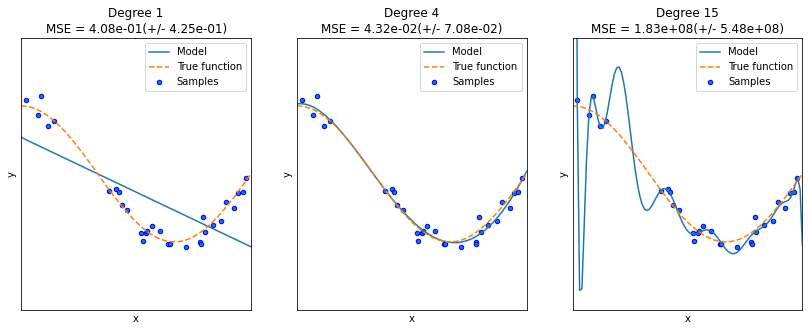

In [23]:
plt.figure(figsize = (14,5))
degrees = [1,4,15]

# 다항 회귀의 차수를 1,4,15로 각각 변화시키면서 비교
for i in range(len(degrees)):
    ax = plt.subplot(1,len(degrees),i + 1)
    plt.setp(ax, xticks=(), yticks =())
    
    # 개별 degree별로 Polynomial 변환
    polynomial_features = PolynomialFeatures(degree = degrees[i], include_bias = False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([('polynomial_features', polynomial_features),
                        ('linear_regression', linear_regression)])
    pipeline.fit(X.reshape(-1, 1),y)
    
    # 교차 검증으로 다항회귀를 평가
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring = 'neg_mean_squared_error', cv = 10)
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0}, 회귀계수는 {1}입니다.'.format(degrees[i], np.round(coefficients,2)))
    print('Degree {0}의 MSE는 {1:.2f}입니다.'.format(degrees[i], -1*np.mean(scores)))
    
    # 0부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행
    X_test = np.linspace(0,1,100)
    
    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label = "Model")
    
    # 실제값 곡선
    plt.plot(X_test, true_fun(X_test),'--', label = "True function")
    plt.scatter(X, y, edgecolors='b',s = 20, label = "Samples")
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((0,1))
    plt.ylim((-2,2))
    plt.legend(loc='best')
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()    
    

  
##### Degree 1 
- 단순한 직선으로 단순 선형 회귀와 똑같다
- 과소적합된 모델  

##### Degree 4 
- 실제 데이터 세트와 유사함
- 변동하는 잡음까지는 예측 못함 but 가장 뛰어난 예측성능  

##### Degree 15 
- 학습데이터만 정확히 예측, 테스트는 전혀 예측못함
- 과적합이 심한 모델

## 5-6. Regularized Linear Models - Ridge, Lasso 

- 최적모델을 위한 cost함수의 구성요소 = (학습데이터의 잔차오류 최소화) + (회귀계수 크기제어)
- 이를 제어하기 위해 alpha(하이퍼파라미터)값을 조정
- alpha를 크게하면 과적합 개선, alpha를 작게하면 학습데이터 적합 개선
- alpha값으로 패널티를 부여해 개선시키는 것을 <q>규제(Regularization)</q>라고함
- 규제의 종류는 L2, L1이 있으며 이에 따라 각각 릿지, 라쏘 회귀가 존재


### 릿지 회귀

- L2 규제를 사용한 회귀
- alpha값이 커질수록 회귀계수 값을 작게 만든다(0으로 가지는 않음)

In [25]:
# 앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data와 Tatget 데이터
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data,y_target, scoring="neg_mean_squared_error",cv = 5)
rmse_scores - np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds의 개별 Negative MSE scores', np.round(neg_mse_scores,3))
print(' 5 folds의 개별 RMSE scores', np.round(rmse_scores,3))
print(' 5 folds의 개별 RMSE : {0:.3f}'.format(avg_rmse))

 5 folds의 개별 Negative MSE scores [-11.437 -24.291 -28.17  -74.673 -28.719]
 5 folds의 개별 RMSE scores [3.533 5.108 5.755 8.991 5.795]
 5 folds의 개별 RMSE : 5.836


In [26]:
# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0,0.1,1,10,100]

# alphas list 값을 iteration 하면서 alpha에 따른 평균 rmse 구함
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    
    # cross_val_score를 이용하여 5fold의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.836
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.796
alpha 1 일 때 5 folds의 평균 RMSE : 5.659
alpha 10 일 때 5 folds의 평균 RMSE : 5.524
alpha 100 일 때 5 folds의 평균 RMSE : 5.332


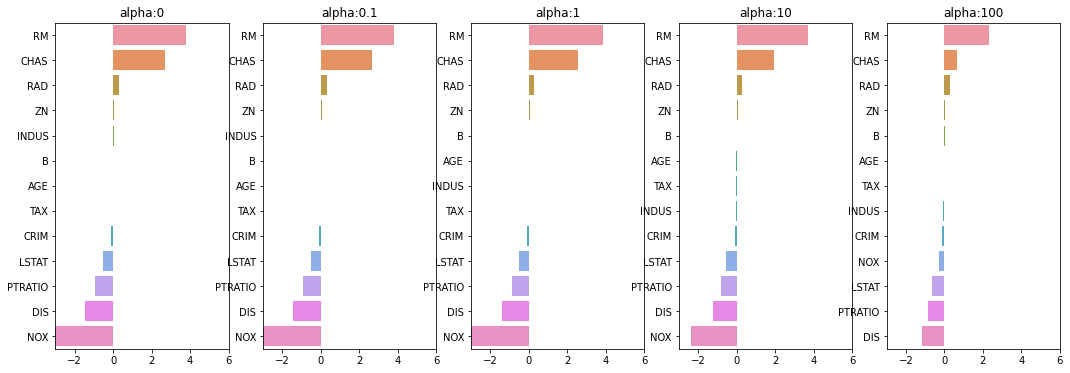

In [28]:
# 각 alpha에 따른 회귀계수 값을 시각화 하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize = (18,6), nrows = 1, ncols = 5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장
# pos는 axis의 위치지정 
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    # 막대 그래프로 각 alpha 값에서의 회귀계수를 시각화, 회귀계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending = False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y = coeff.index , ax = axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피쳐별 회귀계수를 DataFrame으로 표시
plt.show()

In [30]:
ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending = False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.804752,3.813177,3.849256,3.698132,2.331966
CHAS,2.688561,2.671849,2.554221,1.953452,0.638647
RAD,0.305655,0.303105,0.289650,0.279016,0.314915
ZN,0.046395,0.046546,0.047414,0.049547,0.054470
INDUS,0.020860,0.016293,-0.008547,-0.042745,-0.052626
B,0.009393,0.009449,0.009754,0.010117,0.009471
AGE,0.000751,-0.000212,-0.005368,-0.010674,0.001230
TAX,-0.012329,-0.012415,-0.012907,-0.013989,-0.015852
CRIM,-0.107171,-0.106612,-0.103622,-0.100352,-0.101451
LSTAT,-0.525467,-0.526678,-0.534072,-0.560097,-0.661312


### 라쏘 회귀

- L1규제를 사용한 회귀
- 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거(피쳐 셀렉션의 효과도 있음)

In [34]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n = None, verbose = True):
    coeff_df = pd.DataFrame()
    if verbose: 
        print("######",model_name ,"######")
    for param in params:
        if model_name =='Ridge':
            model = Ridge(alpha=param)
        elif model_name =='Lasso':
            model = Lasso(alpha=param)
        elif model_name =='ElasticNet':
            model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = 'neg_mean_squared_error',cv = 5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5폴드 세트의 평균  RMSE: {1:.3f}'.format(param,avg_rmse))

        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)

        # alpha에 따른 피처별 회귀계수를 Series로 변환하고 이를 DataFrame에 컬럼으로 추가
        coeff = pd.Series(data = model.coef_, index = X_data.columns)
        colname = 'alpha:'+str(param)
        coeff_df[colname] = coeff
    
    return coeff_df

In [36]:
# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params = lasso_alphas, X_data_n = X_data, y_target_n=y_target)

###### Lasso ######
alpha 0.07일 때 5폴드 세트의 평균  RMSE: 5.618
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 5.621
alpha 0.5일 때 5폴드 세트의 평균  RMSE: 5.672
alpha 1일 때 5폴드 세트의 평균  RMSE: 5.776
alpha 3일 때 5폴드 세트의 평균  RMSE: 6.189


In [38]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame 출력
coeff_lasso_df.sort_values(by=coeff_lasso_df.columns[0], ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.785460,3.698943,2.494509,0.946786,0.000000
CHAS,1.436287,0.957097,0.000000,0.000000,0.000000
RAD,0.270327,0.274112,0.277118,0.264175,0.061867
ZN,0.049026,0.049179,0.049528,0.049169,0.037231
B,0.010326,0.010327,0.009532,0.008291,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011675,-0.010006,0.003630,0.020927,0.042495
TAX,-0.014287,-0.014567,-0.015440,-0.015209,-0.008602
INDUS,-0.041924,-0.036425,-0.005109,-0.000000,-0.000000
CRIM,-0.097061,-0.096788,-0.082662,-0.063423,-0.000000


### 엘라스틱넷 회귀

- L1과 L2규제를 결합한 회귀
- 파라미터는 alpha와 l1_ratio가 있음
- Ridge나 Lasso회귀의 alpha와는 다름
- l1_ratio = l1_alpha / (l1_alpha + l2_alpha)

In [39]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7fh rhwjd
elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas,
                                      X_data_n = X_data, y_target_n = y_target)


###### ElasticNet ######
alpha 0.07일 때 5폴드 세트의 평균  RMSE: 5.546
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 5.530
alpha 0.5일 때 5폴드 세트의 평균  RMSE: 5.468
alpha 1일 때 5폴드 세트의 평균  RMSE: 5.596
alpha 3일 때 5폴드 세트의 평균  RMSE: 6.068


In [40]:
# 반횐된 coeff_elstic_df를 첫번째 컬럼순으로 내림차순 정렬
coeff_elastic_df.sort_values(by=coeff_elastic_df.columns[0], ascending=  False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.570126,3.410274,1.915894,0.937179,0.000000
CHAS,1.332117,0.980900,0.000000,0.000000,0.000000
RAD,0.278304,0.282881,0.300449,0.289167,0.147089
ZN,0.050074,0.050586,0.052860,0.052126,0.038281
B,0.010200,0.010145,0.009182,0.008373,0.007029
AGE,-0.010084,-0.008248,0.007777,0.020360,0.043445
TAX,-0.014519,-0.014810,-0.016044,-0.016213,-0.011417
INDUS,-0.044641,-0.042520,-0.023093,-0.000000,-0.000000
CRIM,-0.098392,-0.098179,-0.088550,-0.073471,-0.019596
NOX,-0.178164,-0.000000,-0.000000,-0.000000,-0.000000


### 선형회귀 모델을 위한 데이터 변환

- 데이터 분포도의 정규화와 인코딩방법에 따라 예측성능이 좌우됨
- 선형회귀 모델은 피쳐와 타깃값의 분포가 정규 분포형태를 따르는 것을 선호
- 왜곡된 형태의 분포의 경우 예측성능에 부정적인 영향을 줌
- 따라서 데이터에 대한 스케일링/ 정규화 작업이 선행되어야 함

> 대표적인 변환작업
> 1. StandardScaler로 0과 1사이의 값을 표준정규 분포로 변환하거나 MinMaxScaler를 이용해 최소가 0 최대가 1인 값으로 정규화 수행
> 2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항(Polynimial)특성을 적용하여 변환
> 3. 원래값에 log를 적용(가장 많이 쓰이는 방법 / 타깃값에 주로 쓰임) 

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용, p_degree는 2이상 부여하지 않음.
def get_scaled_data(method = 'None', p_degree = None, input_data = None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, 
                                         include_bias = False).fit_transform(scaled_data)
    return scaled_data    

In [42]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출
alphas = [0.1,1,10,100]
# 변환방법은 모두 6개
# 1. 원본그대로 2. 표준정규분포 3. 표준정규분포+다항식
# 4. 최대/최소 정규화, 5.최대/최소 정규화 + 다항식 특성 6. 로그변환
scale_methods = [(None,None),('Standard',None),('Standard',2),
                ('MinMax',None),('MinMax',2),('Log',None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree=scale_method[1],
                                   input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0],scale_method[1]))
    get_linear_reg_eval("Ridge", params=alphas, X_data_n=X_data_scaled,
                       y_target_n=y_target,verbose = False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 5.796
alpha 1일 때 5폴드 세트의 평균  RMSE: 5.659
alpha 10일 때 5폴드 세트의 평균  RMSE: 5.524
alpha 100일 때 5폴드 세트의 평균  RMSE: 5.332

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 5.834
alpha 1일 때 5폴드 세트의 평균  RMSE: 5.810
alpha 10일 때 5폴드 세트의 평균  RMSE: 5.643
alpha 100일 때 5폴드 세트의 평균  RMSE: 5.424

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 8.776
alpha 1일 때 5폴드 세트의 평균  RMSE: 6.849
alpha 10일 때 5폴드 세트의 평균  RMSE: 5.487
alpha 100일 때 5폴드 세트의 평균  RMSE: 4.631

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 5.770
alpha 1일 때 5폴드 세트의 평균  RMSE: 5.468
alpha 10일 때 5폴드 세트의 평균  RMSE: 5.755
alpha 100일 때 5폴드 세트의 평균  RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 5.294
alpha 1일 때 5폴드 세트의 평균  RMSE: 4.320
alpha 10일 때 5폴드 세트의 평균  RMSE: 5.186
alpha 100일 때 5폴드 세트의 평균  RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5폴드 세트의 평균  RMSE: 4.772

결과  
- 로그변환은 전체적으로 성능이 나아짐을 볼 수 있다
- 표준 정규분포와 민맥스 변환은 성능에 큰 변화를 주지 못했다